# Análise das avalizações de usuários de diferentes gerações do produto Echo Dot da Amazon

As avaliações foram coletadas do site da Amazon usando um scrapper contrúido por mim para esse fim.


## Imports e setup


In [1]:
!pip install ntlk


ERROR: Could not find a version that satisfies the requirement ntlk
ERROR: No matching distribution found for ntlk
You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install wordcloud


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install langdetect


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install spacy


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [5]:
!pip install svgling


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [198]:
!pip install transformers


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [413]:
!pip install textblob


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\pbsba\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
!pip install seaborn


In [577]:
!pip install gensim

  Using cached gensim-4.3.1-cp38-cp38-win_amd64.whl (24.0 MB)


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [596]:
!pip install pyLDAvis

You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [448]:
import pandas as pd
import seaborn as sns
import os
import re
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from langdetect import detect, LangDetectException

import spacy
import spacy_transformers
from spacy.tokens import Doc, Span, Token

from textblob import TextBlob

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim 


In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\pbsba\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already

True

In [196]:
!python - m spacy download en_core_web_trf


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


You should consider upgrading via the 'c:\Users\pbsba\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [204]:
!pip install spacy-transformers


You should consider upgrading via the 'c:\users\pbsba\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


## Extração - Scraping


Os datasets gerados pelo scrapper estão na subpasta `datasets`. Cada um foi extraído de um conjunto de páginas de reviews de algum produto Echo Dot.

A Amazon limita o número de páginas de reviews disponíveis para visualização, além de oferecer três opções: "Geral", "Avaliações positivas" e "Avaliações críticas".


## Leitura e pré-processamento


In [9]:
cols = ["product_name", "base_price", "config_price", "bundle_price",
        "name", "stars", "date", "title", "review", "helpful", "config_color"]
orig_dfs = []
for dirpath, dirnames, filenames in os.walk("datasets"):
    for filename in filenames:
        # , names=cols))
        orig_dfs.append(pd.read_csv(
            open(f"{dirpath}/{filename}", "r"), encoding="utf-8"))

orig_df = pd.concat(orig_dfs)
orig_df.reset_index(inplace=True, drop=True)

orig_df.head()


,product_name,base_price,config_price,bundle_price,names,stars,dates,titles,reviews,helpfuls,config_color
0,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,cmax,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Microphone placement seems to be lacking.,\nI think I like the old cylinder style better...,9 people found this helpful,Color: CharcoalConfiguration: Echo
1,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Robert Danger Byrd,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Great as Individual Speakers - Multi Room Just...,"\nI have fully automated, high tech and super ...",17 people found this helpful,Color: CharcoalConfiguration: Echo
2,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Thomas,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,A Powerful Echo - Great for first-time Echo us...,\nQUICK SUMMARY:---------------------------The...,2 people found this helpful,Color: CharcoalConfiguration: Echo
3,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Dad Can't Say No,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,"Doesn't really live up to the hype, Alexa has ...",\n[Edit] This is my second time to edit this r...,One person found this helpful,Color: CharcoalConfiguration: Echo
4,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,RNR,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,This Applies to ALL of our Echoes,\nWe have more than a dozen Echoes in our home...,27 people found this helpful,Color: CharcoalConfiguration: Echo


In [10]:
def check_if_soft_na(x):
    try:
        return x in ['', 0]
    except TypeError:
        return False


def print_df_info(df):
    print(f"{'NAME':^15} {'UNIQ_COUNT':^15} {'NA_COUNT':^15} {'SOFT_NA_COUNT':^15} {'DTYPE':^15}")
    for col in df.columns:
        print(
            f"{col:<15} {len(df[col].unique()):^15} {df[col].isna().sum():^15} {df[col].map(check_if_soft_na).sum():^15} {df[col].dtype.name:^15}")
    print()
    print("SHAPE:", df.shape)
    print("DUPLICATES:", df.duplicated().sum())


print_df_info(orig_df)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             24446             0            float64    
bundle_price           2             24446             0            float64    
names                18775           2732              0            object     
stars                  6             2751              0            object     
dates                1348            2732              0            object     
titles               17936           2762              0            object     
reviews              22253           2886              0            object     
helpfuls              96             36262             0            object     
config_color          28             3465              0            object     

SHAPE: (40487, 11)
DUPLICATES: 9332


In [11]:
orig_df.groupby("product_name")["product_name"].count()


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              13858
Echo_Dot_3rd_Gen_2018_Charcoal                                                        16041
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa     6512
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa            4076
Name: product_name, dtype: int64

Boa parte dos registos não tem avaliações


### Limpeza básica


#### Primeira rodada: filtrando apenas os que tem avaliações únicas


In [12]:
df_filetered = orig_df[~orig_df["reviews"].duplicated()]
print_df_info(df_filetered)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             12574             0            float64    
bundle_price           2             12574             0            float64    
names                18185             1               0            object     
stars                  6              20               0            object     
dates                1348              1               0            object     
titles               16668           1151              0            object     
reviews              22253             1               0            object     
helpfuls              90             19677             0            object     
config_color          28              407              0            object     

SHAPE: (22253, 11)
DUPLICATES: 0


Lidando com NaNs


In [13]:
df_filetered = df_filetered[~df_filetered["reviews"].isna()]
print_df_info(df_filetered)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             12573             0            float64    
bundle_price           2             12573             0            float64    
names                18184             0               0            object     
stars                  6              19               0            object     
dates                1347              0               0            object     
titles               16667           1151              0            object     
reviews              22252             0               0            object     
helpfuls              90             19676             0            object     
config_color          28              406              0            object     

SHAPE: (22252, 11)
DUPLICATES: 0


E os outros NaNs?


#### Segunda rodada: limpando os dados


Olhando para uma amostra, logo se vê uma série de "sujeiras", como NaNs e caractéres especiais


In [643]:
df_filetered.head(10)


,product_name,base_price,config_price,bundle_price,names,stars,dates,titles,reviews,helpfuls,config_color
0,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,cmax,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Microphone placement seems to be lacking.,\nI think I like the old cylinder style better...,9 people found this helpful,Color: CharcoalConfiguration: Echo
1,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Robert Danger Byrd,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Great as Individual Speakers - Multi Room Just...,"\nI have fully automated, high tech and super ...",17 people found this helpful,Color: CharcoalConfiguration: Echo
2,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Thomas,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,A Powerful Echo - Great for first-time Echo us...,\nQUICK SUMMARY:---------------------------The...,2 people found this helpful,Color: CharcoalConfiguration: Echo
3,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Dad Can't Say No,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,"Doesn't really live up to the hype, Alexa has ...",\n[Edit] This is my second time to edit this r...,One person found this helpful,Color: CharcoalConfiguration: Echo
4,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,RNR,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,This Applies to ALL of our Echoes,\nWe have more than a dozen Echoes in our home...,27 people found this helpful,Color: CharcoalConfiguration: Echo
5,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,drol343,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Still just a toy,"\nAfter these things being out all this time, ...",612 people found this helpful,Color: CharcoalConfiguration: Echo
6,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Bookwyrm,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,"Minus stars for deafness, otherwise... great s...",\nUpdate: Echo can only hear you about 1/2 of ...,NaN,Color: CharcoalConfiguration: Echo
7,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,MsKathyB73,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Good for awhile,\nThis worked great for awhile and the round u...,NaN,Color: CharcoalConfiguration: Echo
8,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Dan,3.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,Uncertain,\nThis device works mostly but is limited to b...,NaN,Color: Glacier WhiteConfiguration: Echo
9,Echo_4th_Gen_With_premium_sound_smart_home_hub...,61.76,NaN,NaN,Dr-Phone,1.0 out of 5 stars,Reviewed in the United States \U0001f1fa\U0001...,"For me, more minuses then pluses.",\nI received my echo\u2019s backin Oct. 22nd 2...,NaN,Color: CharcoalConfiguration: Echo


Que outros carácteres especiais aparecem? Além do \n


In [644]:
df_filetered.loc[9]["dates"]


'Reviewed in the United States \\U0001f1fa\\U0001f1f8 on December 17, 2020'

Vamos limpar

- Códigos unicode e carácteres especiais, como \n
- "3.0 out of 5 stars" nas stars. Queremos só o número
- A coluna date contém informações de localização e de data e precisa ser quebrada
- A coluna config_color contém informações da cor e da configuração e precisa ser quebrada
- A coluna helpful contém texto além do número de estrelas


In [645]:
def decode_unicode_codes(s):
    return str(s).encode('utf-8').decode('unicode-escape')


def convert_datestr_to_date(date_str):
    try:
        return datetime.strptime(re.sub("^(.* )on (.*)$", r"\g<2>", date_str), "%B %d, %Y")
    except TypeError:
        pass


def extract_country(country_str):
    try:
        return re.sub("Reviewed in the (.*) on.*$", r"\g<1>", country_str)
    except TypeError:
        pass


def extract_stars_count(starts_str):
    try:
        return int(float(re.sub("^(.*) out.*$", r"\g<1>", starts_str)))
    except TypeError:
        pass
    # except ValueError:
        # return 0


def extract_helpful_count(helpful_str):
    try:
        return int(re.sub("^([0-9]+|One).*$", r"\g<1>", helpful_str).replace("One", "1"))
    except TypeError:
        return 0


In [646]:
df = df_filetered.copy()
print(df.shape)

# fillnas
df["config_price"] = df["config_price"].fillna(0)
df["bundle_price"] = df["bundle_price"].fillna(0)
df["helpfuls"] = df["helpfuls"].fillna(0)
# df["config_color"] = df["config_color"].fillna("")
# df["titles"] = df["titles"].fillna("")
# df["stars"] = df["stars"].fillna("")

# transform contents
df['reviews'] = df['reviews'].str.replace(r"\\n", "").map(decode_unicode_codes)
df['names'] = df['names'].map(decode_unicode_codes)
df['titles'] = df['titles'].map(decode_unicode_codes)
df['country'] = df['dates'].map(decode_unicode_codes).map(extract_country)
df['dates'] = df['dates'].map(convert_datestr_to_date)
df['stars'] = df['stars'].map(extract_stars_count)
df['helpfuls'] = df['helpfuls'].map(extract_helpful_count)
df['configuration'] = df['config_color'].str.replace(
    r"^(.*Configuration: )(.*)$", r"\g<2>")
df['color'] = df['config_color'].str.replace(
    r"^(.*Color: )(.*)(Configuration.*)$", r"\g<2>")


# convert to int
df["stars"] = df["stars"].convert_dtypes(convert_integer=True)
df["helpfuls"] = df["helpfuls"].convert_dtypes(convert_integer=True)

# reorder columns
new_cols = ["dates", "country", "product_name", "configuration",  "color", "base_price",
            "config_price", "bundle_price", "names", "titles", "reviews", "stars", "helpfuls"]
df = df[new_cols]

df


(22252, 11)


C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\3211012428.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['reviews'] = df['reviews'].str.replace(r"\\n", "").map(decode_unicode_codes)
C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\3211012428.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['configuration'] = df['config_color'].str.replace(
C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\3211012428.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['color'] = df['config_color'].str.replace(


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,reviews,stars,helpfuls
0,2023-03-26,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,cmax,Microphone placement seems to be lacking.,"I think I like the old cylinder style better, ...",3,9
1,2023-04-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Robert Danger Byrd,Great as Individual Speakers - Multi Room Just...,"I have fully automated, high tech and super lu...",1,17
2,2021-10-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Thomas,A Powerful Echo - Great for first-time Echo us...,QUICK SUMMARY:---------------------------The 4...,3,2
3,2021-01-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Dad Can't Say No,"Doesn't really live up to the hype, Alexa has ...",[Edit] This is my second time to edit this rev...,1,1
4,2023-03-31,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,RNR,This Applies to ALL of our Echoes,We have more than a dozen Echoes in our home (...,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40420,2022-11-30,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Glacier White,39.99,0.0,0.0,Amazon Customer,for my son,My son will love it. it for Xmas,5,3
40426,2022-10-24,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Cloud Blue,39.99,0.0,0.0,Jersey Stitch Witch,Fabulous,"I love the great sound, the easy interaction w...",5,0
40427,2023-02-02,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Glacier White,39.99,0.0,0.0,Courtnie Newcomb,CANNOT LIVE WITHOUT,I really really love how we can ask Alexa a qu...,5,0
40437,2023-03-03,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Cloud Blue,39.99,0.0,0.0,Enrique Gómez,Alexa,Ideal para interactuar con los productos Smart...,5,0


In [647]:
print_df_info(orig_df)
print()
print_df_info(df)


     NAME         UNIQ_COUNT       NA_COUNT      SOFT_NA_COUNT       DTYPE     
product_name           4               0               0            object     
base_price             4               0               0            float64    
config_price           2             24446             0            float64    
bundle_price           2             24446             0            float64    
names                18775           2732              0            object     
stars                  6             2751              0            object     
dates                1348            2732              0            object     
titles               17936           2762              0            object     
reviews              22253           2886              0            object     
helpfuls              96             36262             0            object     
config_color          28             3465              0            object     

SHAPE: (40487, 11)
DUPLICATES: 9332

  

Ainda sobraram muitos registos. Qual o tamanho do corpus?


In [648]:
df['reviews'].map(len).sum()


6043187

Meio milhão de palvras!


### Downsampling


Para manter o processamento rápido, vamos trabalhar com sub-amostras de avaliações cada produto


In [649]:
df.groupby("product_name")["product_name"].count()


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              8155
Echo_Dot_3rd_Gen_2018_Charcoal                                                        9679
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    2728
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           1690
Name: product_name, dtype: int64

In [650]:
def downsample_df_to_n_rows(df, n):
    df = df.groupby("product_name").head(n)
    print(df.groupby("product_name")["product_name"].count())
    return df


In [651]:
df = downsample_df_to_n_rows(df, 100)


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              100
Echo_Dot_3rd_Gen_2018_Charcoal                                                        100
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    100
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           100
Name: product_name, dtype: int64


In [652]:
df['reviews'].map(len).sum()


326955

### Idioma


#### Identificando o idioma


In [653]:
try:
    df.insert(df.columns.get_loc("titles")+1, "title_lang", "")
    df.insert(df.columns.get_loc("reviews")+1, "review_lang", "")
except ValueError:
    ...


def f(s):
    try:
        return detect(s)
    except LangDetectException:
        return "NO_LANG"


df["title_lang"] = df["titles"].map(f)
df["review_lang"] = df["reviews"].map(f)
df.head()


C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\931494984.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["title_lang"] = df["titles"].map(f)
C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\931494984.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_lang"] = df["reviews"].map(f)


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
0,2023-03-26,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,cmax,Microphone placement seems to be lacking.,en,"I think I like the old cylinder style better, ...",en,3,9
1,2023-04-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Robert Danger Byrd,Great as Individual Speakers - Multi Room Just...,en,"I have fully automated, high tech and super lu...",en,1,17
2,2021-10-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Thomas,A Powerful Echo - Great for first-time Echo us...,en,QUICK SUMMARY:---------------------------The 4...,en,3,2
3,2021-01-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Dad Can't Say No,"Doesn't really live up to the hype, Alexa has ...",en,[Edit] This is my second time to edit this rev...,en,1,1
4,2023-03-31,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,RNR,This Applies to ALL of our Echoes,en,We have more than a dozen Echoes in our home (...,en,3,27


#### Lidando com detecções erradas e selecionando apenas o Inglês


Em alguns casos, não houve deteção da língua


In [654]:
df[df["review_lang"].str.startswith("NO_LANG")]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


Vamos ignorá-los


In [655]:
df = df[~df["review_lang"].str.startswith("NO_LANG")]
df[df["review_lang"].str.startswith("NO_LANG")]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


Pelo país ser EUA, deveria haver apenas inglês ou espanhol


In [656]:
df[df["review_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
86,2023-02-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.00,0.00,milotl,Nice,ro,I'll buy it again,tl,3,0
3443,2023-03-24,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,NaN,NaN,22.92,15.06,59.98,Amazon Customer,Look into device info.,en,Stopped working,af,3,0
3461,2023-03-16,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,Device only,Configuration: Device only,22.92,15.06,59.98,Jess,She doesn't seems to respond to question corre...,en,N/a,tl,3,0
8524,2023-04-28,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,Device only,Deep Sea Blue,29.99,0.00,0.00,martina,For a small area,en,Volume doesn’t get loud,af,3,0


In [657]:
df["review_lang"].value_counts().head(5)


en    383
es     13
tl      2
af      2
Name: review_lang, dtype: int64

In [658]:
df[df["review_lang"] == "af"].head(5)


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
3443,2023-03-24,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,NaN,NaN,22.92,15.06,59.98,Amazon Customer,Look into device info.,en,Stopped working,af,3,0
8524,2023-04-28,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,Device only,Deep Sea Blue,29.99,0.00,0.00,martina,For a small area,en,Volume doesn’t get loud,af,3,0


Ele errou o idioma de algumas avaliações. Como não são muitas, vamos ignorar também. Em um trabalho futuro, podemos tentar tratar esses erros


In [659]:
df = df[~df["review_lang"].map(lambda s: s not in ["en", "es"])]
df[df["review_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [660]:
df["review_lang"].value_counts()


en    383
es     13
Name: review_lang, dtype: int64

E dos títulos?


In [661]:
df[df["title_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
8,2023-04-29,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Glacier White,61.76,0.0,0.0,Dan,Uncertain,fr,This device works mostly but is limited to bei...,en,3,0
13,2023-04-13,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Eric V,Not bad,id,I liked my first generation better. Had better...,en,3,1
16,2023-04-28,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Glacier White,61.76,0.0,0.0,John Murphy,Good Looking design,af,"Not a fan of the new version, it doesn't respo...",en,3,0
17,2023-04-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Jodi,Echo Gen 1 is Better,de,I had the original Echo 1 until my cats knocke...,en,3,0
23,2022-07-10,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,mike in mass,JUst an OK upgrade,sv,What I liked – Better bass that my original ec...,en,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9289,2022-12-09,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Glacier White,39.99,0.0,0.0,KLO KC,VERY BRIGHT_,de,"This is a great product, purchased on sale ho...",en,3,0
9294,2022-12-23,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Cloud Blue,39.99,0.0,0.0,Jeremiah,Just okay,fi,It's Okay that's all it isSound Quality OkayRa...,en,3,3
9299,2022-12-22,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Cloud Blue,39.99,0.0,0.0,Amazon Customer,Not as good,af,Voice recognition is not as good as the gen fo...,en,3,0
9301,2022-11-30,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Glacier White,39.99,0.0,0.0,SMB,Seems like a downgrade not an upgrade,af,The clock is much harder to see then the previ...,en,3,0


Errou muito mais nos títulos, por serem strings menores. Vamos propagar as detecções das reviews


In [662]:
df.loc[df["title_lang"].map(lambda s: s not in ["en", "es"]), "title_lang"] = df[df["title_lang"].map(
    lambda s: s not in ["en", "es"])]["review_lang"]
df[df["title_lang"].map(lambda s: s not in ["en", "es"])]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [663]:
df["title_lang"].value_counts()


en    383
es     13
Name: title_lang, dtype: int64

As pessoas escreveriam o título em uma língua e a avaliação em outra?


In [664]:
df[df["title_lang"] != df["review_lang"]].head()


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls
77,2023-01-22,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Glacier White,61.76,0.00,0.00,Jeffrey,No More Than a Novelty,en,Hace poco la compré y lamentablemente empezó a...,es,3,0
78,2023-01-27,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Twilight Blue,61.76,0.00,0.00,maria copher,Ha estado fallando en reconocimiento de la voz,es,I purchased this machine in Dec 2021. It was w...,en,2,0
3453,2023-02-14,United States 🇺🇸,Echo_Dot_3rd_Gen_2018_Charcoal,NaN,NaN,22.92,15.06,59.98,Ida Gómez,New version of Amazon Music is a travesty,en,Compré 2 dispositivos en diciembre pero uno de...,es,3,0
8581,2023-01-28,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_With_bigger_vibr...,Device only,Charcoal,29.99,0.00,0.00,Eduardo,Pfft... I have no idea,en,"Considero que la 3era gerenacion era mejor, te...",es,3,0
9222,2023-03-13,United States 🇺🇸,Echo_Dot_5th_Gen_2022_release_with_clock_Smart...,Device only,Cloud Blue,39.99,0.00,0.00,cytherea,nice design,es,I like the design and color with the clock dis...,en,3,0


Parece que em muitos casos, de fato são pessoas bilingues. Como são poucos casos, vamos ignorar


In [665]:
df = df[df["title_lang"] == df["review_lang"]]
df[df["title_lang"] != df["review_lang"]]


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls


In [666]:
df.groupby("review_lang")["review_lang"].count()


review_lang
en    380
es     10
Name: review_lang, dtype: int64

E, finalmente, como há pouquíssimas avaliações em espanhol, por simplicidade, vamos ignorá-las.


In [667]:
df = df[df["review_lang"] == "en"]
df.groupby("review_lang")["review_lang"].count()


review_lang
en    380
Name: review_lang, dtype: int64

In [668]:
df.groupby("product_name")["product_name"].count()


product_name
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa                              97
Echo_Dot_3rd_Gen_2018_Charcoal                                                        94
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa    94
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa           95
Name: product_name, dtype: int64

Normalizando os datasets


In [669]:
# df = downsample_df_to_n_rows(df, 1250)


## Entidades nomeadas e POS Tagging


Quantas palavras no corpus?


In [670]:
df['reviews'].map(len).sum()


322923

In [671]:
reviews = ' '.join(df['reviews'])


In [672]:
# nlp = spacy.load('en_core_web_trf')
nlp = spacy.load('en_core_web_sm')


In [673]:
reviews = ' '.join(df['reviews'])
nlp.max_length = 2_500_000
doc = nlp(reviews)


## Exploração


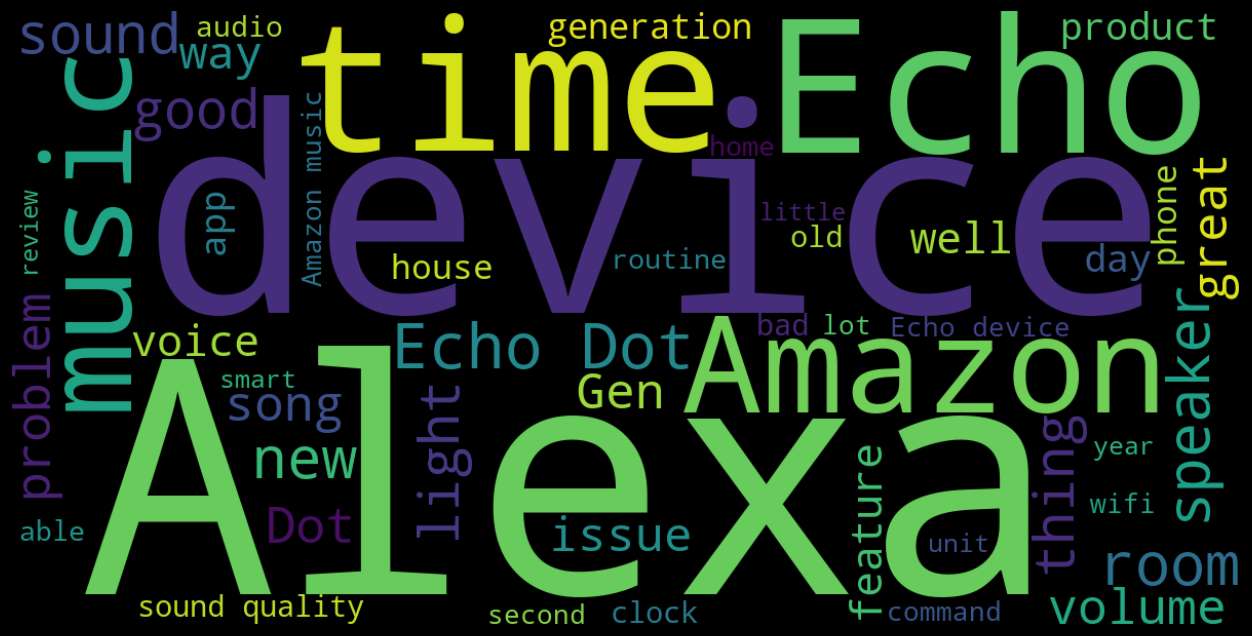

In [674]:
words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop if token.pos_ in [
    'NOUN', 'ADJ', 'PROPN']]

wordcloud = WordCloud(background_color="black", max_words=50,
                      width=1200, height=600).generate(' '.join(words_filtered))

plt.figure(figsize=(16, 8), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


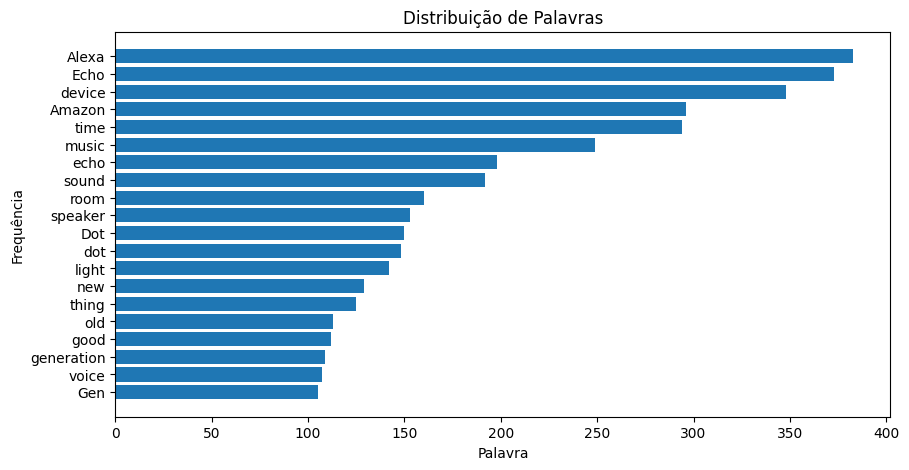

In [675]:
contagem = Counter(words_filtered).most_common(20)
words, freqs = [], []
for tup in contagem[::-1]:
    words.append(tup[0])
    freqs.append(tup[1])


# Criar um gráfico de barras para visualizar a distribuição de palavras
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(words, freqs)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()


Hmm, parece que seria interessante remover "alexa", "device" e palavras do tipo...


## Limpeza usando tokenização, lematização e entidades nomeadas


In [676]:
ents = [token for token in doc if token.ent_type]

print(f"{'token.text':^15} {'token.lemma_':^15} {'token.pos_':^15} {'token.tag_':^15} {'token.dep_':^15}"
      f"{'token.shape_':^15} {'token.is_alpha':^15} {'token.is_stop':^15} {'token.ent_type':^15} {'token.ent_type_':^15}")
for token in ents[:20]:
    print(f"{token.text:^15} {token.lemma_:^15} {token.pos_:^15} {token.tag_:^15} {token.dep_:^15}"
          f"{token.shape_:^15} {token.is_alpha:^15} {token.is_stop:^15} {token.ent_type:^15} {token.ent_type_:^15}")


  token.text     token.lemma_     token.pos_      token.tag_      token.dep_    token.shape_   token.is_alpha   token.is_stop  token.ent_type  token.ent_type_
      one             one             NUM             CD             dobj            xxx              1               1              397          CARDINAL    
      70              70              NUM             CD            nummod           dd               0               0              393           PERCENT    
       %               %             NOUN             NN             conj             %               0               0              393           PERCENT    
     three           three            NUM             CD            nummod          xxxx              1               1              397          CARDINAL    
      80              80              NUM             CD            nummod           dd               0               0              393           PERCENT    
       %               %             NOUN     

In [677]:
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"][:20])
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks][:10])


Verbs: ['think', 'like', 'take', 'know', '’', '’', 'seem', 'hear', 'get', 'sit', 'use', 'have', 'repeat', 'go', 'recognize', 'hear', 'design', 'look', 'integrate', 'change']
Noun phrases: ['I', 'I', 'the old cylinder style', 'smaller footprint', 'countertop', 'it', 'the extra height', 'microphone placement', 'it', 'me']


In [678]:
from spacy import displacy
displacy.render(doc[:100], style="ent", jupyter=True)


c:\Users\pbsba\AppData\Local\Programs\Python\Python38\lib\site-packages\spacy\displacy\__init__.py:71: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [679]:
org_ents = [ent for ent in ents if ent.ent_type_ == "ORG"]
print(len(org_ents))
org_ents


1332


[Alexa,
 Amazon,
 Cliffwood,
 Alexas,
 Alexa,
 Echos,
 Amazon,
 Fire,
 TV,
 Xfinity,
 Amazon,
 Router,
 Amazon.com,
 PC,
 Magazine,
 and,
 Toms,
 Hardware,
 Guide,
 The,
 Home,
 Theater,
 The,
 Alexa,
 Echo,
 4th,
 Gen,
 Studio,
 Alexas,
 Amazon,
 Alexas,
 Rooms,
 Orbi,
 Alexas,
 Amazon,
 alexas,
 Xfinity,
 Alexa,
 Amazon,
 Alexa,
 Amazon,
 Echo,
 Alexa,
 Alexa,
 Amazon,
 Echo,
 Amazon,
 Echo,
 Prime,
 Echo,
 Amazon,
 Music,
 knowledgeEnvironment:---------------------------The,
 Echo,
 white,
 noise).PROS:---------------------------•,
 Sound,
 Reproduction,
 Amazon,
 Alexa,
 Echo,
 Echo,
 Alexa,
 Alexa,
 Alexa,
 CONS:---------------------------•,
 Voice,
 Recognition,
 Echo,
 Amazon,
 Echo,
 Google,
 Nest,
 Amazon,
 Echo,
 Google,
 Nest,
 Alexa,
 Alexa,
 the,
 Google,
 Nest,
 Amazon,
 Echo,
 Google,
 Nest,
 Amazon,
 Echo,
 Echo,
 Ebay,
 Google,
 Nest,
 the,
 Google,
 Nest,
 Amazon,
 Google,
 Target,
 Echo,
 Amazon,
 Alexa,
 Alexa,
 Alexa,
 Alexa,
 Echo,
 Alexa,
 Alexa,
 Alexa,
 Alexa,


In [680]:
len(doc)


69588

Atributos adicionais para filtragem de entidades indesejadas


In [681]:
Token.set_extension("is_alexa", getter=lambda token: token.lemma_.lower() in [
                    "alexa", "alexas"], force=True)
Token.set_extension("is_echo", getter=lambda token: token.lemma_.lower() in [
                    "echo", "echos", "dot"], force=True)
Token.set_extension("is_amazon", getter=lambda token: bool(
    re.search("amazon(.[A-Za-z]*)?", token.lemma_.lower())), force=True)
Token.set_extension(
    "is_device", getter=lambda token: token.lemma_.lower() == "device", force=True)
len([token for token in doc if token._.is_alexa])


436

In [682]:
org_ends_s = pd.Series(org_ents)
org_ends_s[~org_ends_s.map(
    lambda t: t._.is_alexa or t._.is_echo or t._.is_amazon or t._.is_device)].tolist()


[Cliffwood,
 Fire,
 TV,
 Xfinity,
 Router,
 PC,
 Magazine,
 and,
 Toms,
 Hardware,
 Guide,
 The,
 Home,
 Theater,
 The,
 4th,
 Gen,
 Studio,
 Rooms,
 Orbi,
 Xfinity,
 Prime,
 Music,
 knowledgeEnvironment:---------------------------The,
 white,
 noise).PROS:---------------------------•,
 Sound,
 Reproduction,
 CONS:---------------------------•,
 Voice,
 Recognition,
 Google,
 Nest,
 Google,
 Nest,
 the,
 Google,
 Nest,
 Google,
 Nest,
 Ebay,
 Google,
 Nest,
 the,
 Google,
 Nest,
 Google,
 Target,
 Music,
 Music,
 Music,
 AT&T,
 iPad,
 AT&T,
 AT&T,
 the,
 4th,
 Generation,
 ZZZ,
 4th,
 Gen,
 Unlimited,
 Music,
 Prime,
 Music,
 Everywhere,
 My,
 Everywhere,
 Group,
 NPR,
 /,
 Kuow,
 iHeart,
 Radio,
 Lists,
 &,
 Notes,
 Skills,
 Chart,
 Blueprints,
 the,
 Help,
 &,
 Feedback,
 Find,
 Fire,
 TV,
 Fire,
 TV,
 Fire,
 TV,
 Omni,
 KOAA,
 Glacier,
 Mids,
 Update,
 KEEP,
 CS,
 CS,
 CS,
 STILL,
 CS,
 DEFECTIVE,
 CS,
 CS,
 Prior,
 4,
 CS,
 what--"tech,
 Concerning,
 /,
 Engineer,
 the,
 Gen,
 4,
 B

In [683]:
filtered_ers = pd.Series(
    [token.text for token in doc
        if token._.is_alexa or token._.is_echo or token._.is_amazon or token._.is_device
     ]).unique().tolist()
len(filtered_ers)


29

In [684]:
words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop if token.pos_ in [
    'NOUN', 'ADJ', 'PROPN']]


In [685]:
words_fileter_without_ners = [
    w for w in words_filtered if w not in filtered_ers]


In [686]:
print(len(words_filtered))
print(len(words_fileter_without_ners))


16157
14120


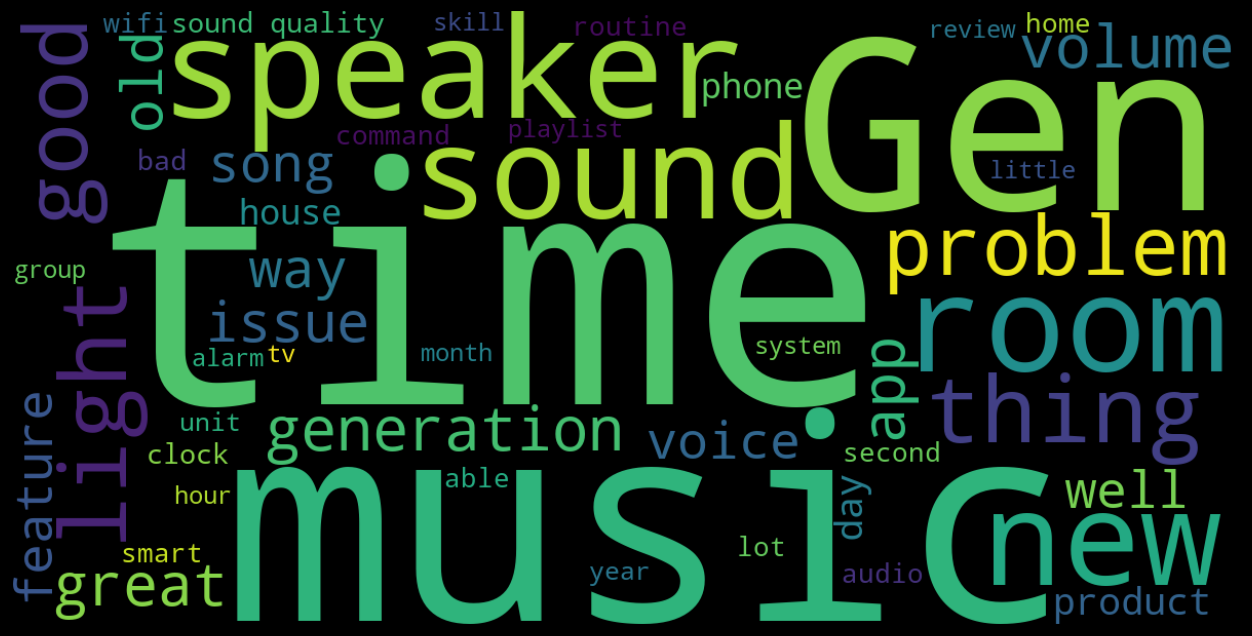

In [687]:
wordcloud = WordCloud(background_color="black", max_words=50, width=1200,
                      height=600).generate(' '.join(words_fileter_without_ners))

plt.figure(figsize=(16, 8), facecolor='k')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


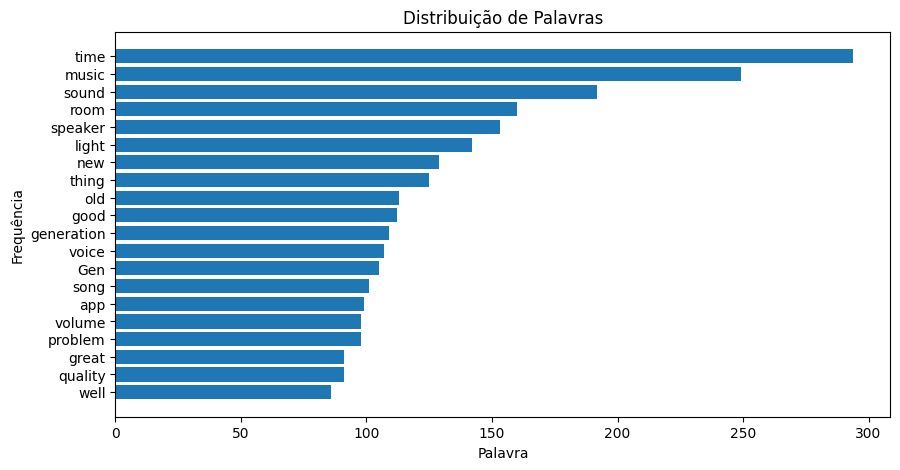

In [688]:
contagem = Counter(words_fileter_without_ners).most_common(20)
words, freqs = [], []
for tup in contagem[::-1]:
    words.append(tup[0])
    freqs.append(tup[1])


# Criar um gráfico de barras para visualizar a distribuição de palavras
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(words, freqs)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.title('Distribuição de Palavras')
plt.show()


### Limpando o dataset


In [690]:
Token.set_extension("is_alexa", getter=lambda token: token.lemma_.lower() in [
                    "alexa", "alexas"], force=True)
Token.set_extension("is_echo", getter=lambda token: token.lemma_.lower() in [
                    "echo", "echos", "dot"], force=True)
Token.set_extension("is_amazon", getter=lambda token: bool(
    re.search("amazon(.[A-Za-z]*)?", token.lemma_.lower())), force=True)
Token.set_extension(
    "is_device", getter=lambda token: token.lemma_.lower() == "device", force=True)


In [691]:
def clean_doc(doc):
    filtered_ers = pd.Series(
        [token.text for token in doc
            if token._.is_alexa or token._.is_echo or token._.is_amazon or token._.is_device
         ]).unique().tolist()
    len(filtered_ers)

    words_filtered = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ in [
        'NOUN', 'ADJ', 'PROPN']]
    return " ".join([w for w in words_filtered if w not in filtered_ers])


In [692]:
df["docs"] = df["reviews"].map(nlp)
df["clean_reviews"] = df["docs"].map(clean_doc)
df.head()


C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\3773285046.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filtered_ers = pd.Series(


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews
0,2023-03-26,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,cmax,Microphone placement seems to be lacking.,en,"I think I like the old cylinder style better, ...",en,3,9,"(I, think, I, like, the, old, cylinder, style,...",old cylinder style small footprint countertop ...
1,2023-04-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Robert Danger Byrd,Great as Individual Speakers - Multi Room Just...,en,"I have fully automated, high tech and super lu...",en,1,17,"(I, have, fully, automated, ,, high, tech, and...",high tech luxurious airbnb Cliffwood Experienc...
2,2021-10-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Thomas,A Powerful Echo - Great for first-time Echo us...,en,QUICK SUMMARY:---------------------------The 4...,en,3,2,"(QUICK, SUMMARY:---------------------------The...",QUICK generation welcome upgrade previous gene...
3,2021-01-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Dad Can't Say No,"Doesn't really live up to the hype, Alexa has ...",en,[Edit] This is my second time to edit this rev...,en,1,1,"([, Edit, ], This, is, my, second, time, to, e...",second time review review original star star p...
4,2023-03-31,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,RNR,This Applies to ALL of our Echoes,en,We have more than a dozen Echoes in our home (...,en,3,27,"(We, have, more, than, a, dozen, Echoes, in, o...",dozen echo home husband bit obsessed past coup...


In [693]:
df[["reviews", "clean_reviews"]].applymap(len).head()


,reviews,clean_reviews
0,2449,737
1,4097,1644
2,5425,2034
3,5838,1438
4,929,258


In [695]:
df.iloc[0][["reviews", "clean_reviews"]]


reviews          I think I like the old cylinder style better, ...
clean_reviews    old cylinder style small footprint countertop ...
Name: 0, dtype: object

## Análise de sentimentos


In [696]:
blob = TextBlob(df.iloc[0]["reviews"])
print(blob.sentiment)

blob = TextBlob(df.iloc[0]["clean_reviews"])
print(blob.sentiment)

print(df.iloc[0][["stars"]])


Sentiment(polarity=0.10036439624205586, subjectivity=0.4548240766325871)
Sentiment(polarity=0.12521645021645023, subjectivity=0.49494833123865384)
stars    3
Name: 0, dtype: object


In [697]:
df["sentiment"] = df["clean_reviews"].map(lambda x: TextBlob(x).sentiment[0])
df["subjectivity"] = df["clean_reviews"].map(
    lambda x: TextBlob(x).sentiment[1])
df.head()


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews,sentiment,subjectivity
0,2023-03-26,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,cmax,Microphone placement seems to be lacking.,en,"I think I like the old cylinder style better, ...",en,3,9,"(I, think, I, like, the, old, cylinder, style,...",old cylinder style small footprint countertop ...,0.125216,0.494948
1,2023-04-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Robert Danger Byrd,Great as Individual Speakers - Multi Room Just...,en,"I have fully automated, high tech and super lu...",en,1,17,"(I, have, fully, automated, ,, high, tech, and...",high tech luxurious airbnb Cliffwood Experienc...,0.223794,0.544884
2,2021-10-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Thomas,A Powerful Echo - Great for first-time Echo us...,en,QUICK SUMMARY:---------------------------The 4...,en,3,2,"(QUICK, SUMMARY:---------------------------The...",QUICK generation welcome upgrade previous gene...,0.068863,0.404293
3,2021-01-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Dad Can't Say No,"Doesn't really live up to the hype, Alexa has ...",en,[Edit] This is my second time to edit this rev...,en,1,1,"([, Edit, ], This, is, my, second, time, to, e...",second time review review original star star p...,0.035779,0.493789
4,2023-03-31,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,RNR,This Applies to ALL of our Echoes,en,We have more than a dozen Echoes in our home (...,en,3,27,"(We, have, more, than, a, dozen, Echoes, in, o...",dozen echo home husband bit obsessed past coup...,-0.045833,0.495833


Há alguma correlação?


<AxesSubplot:>

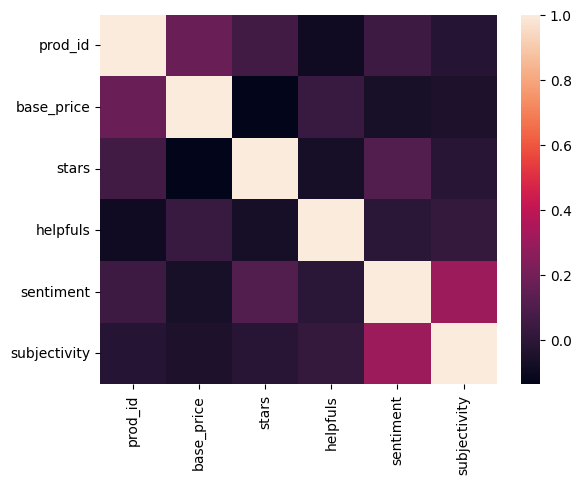

In [698]:
tmp_df = df.copy()
tmp_df["prod_id"] = df["product_name"].map(len)
tmp_df[["prod_id", "base_price", "stars",
        "helpfuls", "sentiment", "subjectivity"]].corr()
sns.heatmap(tmp_df[["prod_id", "base_price", "stars",
            "helpfuls", "sentiment", "subjectivity"]].corr())


In [699]:
df.groupby("product_name").agg({"sentiment": "mean", "stars": "mean"})


,sentiment,stars
product_name,,
Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa,0.087988,2.639175
Echo_Dot_3rd_Gen_2018_Charcoal,0.127926,2.787234
Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa,0.126542,2.904255
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa,0.179063,2.757895


Não há correlação entre o sentimento e qualquer outra váriavels. No entanto, há uma leve correlação entre o produto e o número de estrelas, o que indica que há variação da percepção de valor dos clientes entre as gerações do Echo Dot


E o tempo?


Vamos fracionar em períodos de 30 dias


In [700]:
print(df.dates.min())
print(df.dates.max())
print(df.dates.max() - df.dates.min())
print("bins", ((df.dates.max() - df.dates.min()).days/90))
print((df.dates.max() - df.dates.min()) /
      ((df.dates.max() - df.dates.min()).days/90))


2019-09-30 00:00:00
2023-04-30 00:00:00
1308 days 00:00:00
bins 14.533333333333333
90 days 00:00:00


In [701]:
df["date_bins"] = pd.cut(df["dates"], int(
    ((df.dates.max() - df.dates.min()).days/90)))
df["date_bins"] = df["date_bins"].map(lambda x: x.left.date())
df.head()


,dates,country,product_name,configuration,color,base_price,config_price,bundle_price,names,titles,title_lang,reviews,review_lang,stars,helpfuls,docs,clean_reviews,sentiment,subjectivity,date_bins
0,2023-03-26,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,cmax,Microphone placement seems to be lacking.,en,"I think I like the old cylinder style better, ...",en,3,9,"(I, think, I, like, the, old, cylinder, style,...",old cylinder style small footprint countertop ...,0.125216,0.494948,2023-01-26
1,2023-04-21,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Robert Danger Byrd,Great as Individual Speakers - Multi Room Just...,en,"I have fully automated, high tech and super lu...",en,1,17,"(I, have, fully, automated, ,, high, tech, and...",high tech luxurious airbnb Cliffwood Experienc...,0.223794,0.544884,2023-01-26
2,2021-10-03,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Thomas,A Powerful Echo - Great for first-time Echo us...,en,QUICK SUMMARY:---------------------------The 4...,en,3,2,"(QUICK, SUMMARY:---------------------------The...",QUICK generation welcome upgrade previous gene...,0.068863,0.404293,2021-07-15
3,2021-01-14,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,Dad Can't Say No,"Doesn't really live up to the hype, Alexa has ...",en,[Edit] This is my second time to edit this rev...,en,1,1,"([, Edit, ], This, is, my, second, time, to, e...",second time review review original star star p...,0.035779,0.493789,2021-01-09
4,2023-03-31,United States 🇺🇸,Echo_4th_Gen_With_premium_sound_smart_home_hub...,Echo,Charcoal,61.76,0.0,0.0,RNR,This Applies to ALL of our Echoes,en,We have more than a dozen Echoes in our home (...,en,3,27,"(We, have, more, than, a, dozen, Echoes, in, o...",dozen echo home husband bit obsessed past coup...,-0.045833,0.495833,2023-01-26


In [702]:
df["product_name"].unique()


array(['Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa',
       'Echo_Dot_3rd_Gen_2018_Charcoal',
       'Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa',
       'Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa'],
      dtype=object)

In [703]:
prod_id_map = {
    'Echo_Dot_3rd_Gen_2018_Charcoal': 1,
    'Echo_4th_Gen_With_premium_sound_smart_home_hub_and_Alexa': 2,
    'Echo_Dot_5th_Gen_2022_release_With_bigger_vibrant_sound_helpful_routines_and_Alexa': 3,
    'Echo_Dot_5th_Gen_2022_release_with_clock_Smart_speaker_with_clock_and_Alexa': 4
}


               prod_id  base_price     stars  helpfuls  sentiment  \
prod_id       1.000000    0.141234  0.035815 -0.096947   0.092203   
base_price    0.141234    1.000000 -0.137273  0.035681  -0.062641   
stars         0.035815   -0.137273  1.000000 -0.067878   0.103392   
helpfuls     -0.096947    0.035681 -0.067878  1.000000  -0.010778   
sentiment     0.092203   -0.062641  0.103392 -0.010778   1.000000   
subjectivity  0.024307   -0.049339 -0.015143  0.021498   0.306245   
date_bins     0.184573   -0.217619  0.217495 -0.140063   0.036745   

              subjectivity  date_bins  
prod_id           0.024307   0.184573  
base_price       -0.049339  -0.217619  
stars            -0.015143   0.217495  
helpfuls          0.021498  -0.140063  
sentiment         0.306245   0.036745  
subjectivity      1.000000  -0.086069  
date_bins        -0.086069   1.000000  


<AxesSubplot:>

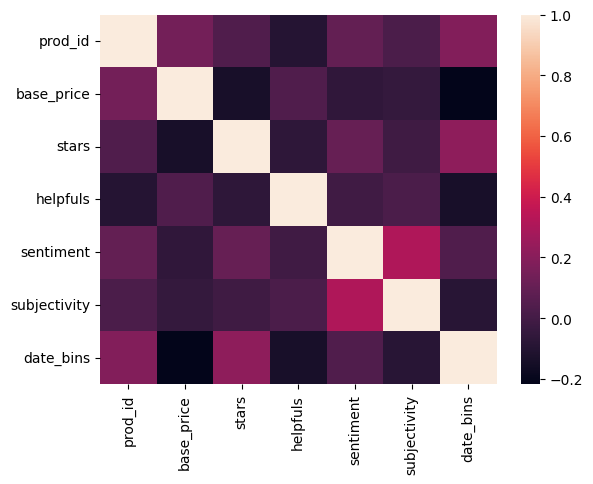

In [704]:
tmp_df = df.copy()
tmp_df["prod_id"] = df["product_name"].map(lambda x: prod_id_map[x])
tmp_df["date_bins"] = df["date_bins"].map(
    lambda x: 10000*x.year + 100*x.month + x.day).astype(int)
# tmp_df[["prod_id", "base_price", "stars", "helpfuls","sentiment","subjectivity","date_bins"]].corr()
print(tmp_df[["prod_id", "base_price", "stars", "helpfuls",
      "sentiment", "subjectivity", "date_bins"]].corr())
sns.heatmap(tmp_df[["prod_id", "base_price", "stars", "helpfuls",
            "sentiment", "subjectivity", "date_bins"]].corr())


In [705]:
print(df.dates.min())
print(df.dates.max())
df.groupby(["product_name", "date_bins"]).agg(
    {"sentiment": "mean", "stars": "mean"}).sort_values(["stars", "sentiment"], ascending=False).head(20)


2019-09-30 00:00:00
2023-04-30 00:00:00


sentiment  \
product_name                                       date_bins               
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-07-23   0.254233   
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-07-23   0.148229   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-04-12   0.133726   
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-04-21   0.124933   
                                                   2022-01-17   0.037121   
                                                   2020-10-07  -0.059562   
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2022-10-25   0.085338   
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-10-25   0.132160   
                                                   2023-01-26   0.132565   
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2023-01-26   0.139890   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-10-25   0.114714   
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-10-25   0.176599   
                                                   2023-01-26   0.176626   
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-07-15   0.102339   
                                                   2023-01-26   0.067345   
                                                   2022-07-23   0.089514   
                                                   2021-10-16   0.121755   
                                                   2022-04-21   0.096828   
                                                   2020-10-07   0.092531   
Echo_Dot_3rd_Gen_2018_Charcoal                     2019-09-28   0.060100   

                                                                  stars  
product_name                                       date_bins             
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-07-23       3.0  
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-07-23       3.0  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-04-12       3.0  
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-04-21       3.0  
                                                   2022-01-17       3.0  
                                                   2020-10-07       3.0  
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2022-10-25  2.956522  
Echo_Dot_3rd_Gen_2018_Charcoal                     2022-10-25  2.941176  
                                                   2023-01-26  2.910714  
Echo_Dot_5th_Gen_2022_release_With_bigger_vibra... 2023-01-26  2.887324  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2022-10-25  2.869565  
Echo_Dot_5th_Gen_2022_release_with_clock_Smart_... 2022-10-25  2.816327  
                                                   2023-01-26  2.674419  
Echo_4th_Gen_With_premium_sound_smart_home_hub_... 2021-07-15  2.666667  
                                                   2023-01-26   2.65625  
                                                   2022-07-23  2.571429  
                                                   2021-10-16  2.555556  
                                                   2022-04-21       2.5  
                                                   2020-10-07  2.444444  
Echo_Dot_3rd_Gen_2018_Charcoal                     2019-09-28  2.333333

O período também apresenta uma leve correlação com a quantidade de estrelas


Há também um sentimento positivo mais forte em relação ao último Echo Dot 5 com relógio. De fato, a palavra "Time" apareceu bastante na nuvem de palavras e agora sabemos o porquê.

## Tópicos

In [712]:
def analyze_topics(df):
    def make_n_grams(text):
        text = text.split()
        bigram = Phrases(text, min_count=5, threshold=100)
        trigram = Phrases(bigram[text], threshold=100)
        return trigram[bigram[text]]

    df["ngrams"] = df["clean_reviews"].map(make_n_grams)

    dictionary = Dictionary(df['ngrams'])
    corpus = [dictionary.doc2bow(text) for text in df['ngrams']]

    num_topics = 5

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

    for i, topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=5):
        print('Topic {}: {}'.format(i, topic))

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return(vis)
analyze_topics(df)

Topic 0: 0.027*"sound" + 0.018*"generation" + 0.013*"speaker" + 0.012*"gen" + 0.011*"quality"
Topic 1: 0.019*"time" + 0.016*"light" + 0.015*"room" + 0.011*"good" + 0.011*"old"
Topic 2: 0.014*"Gen" + 0.012*"volume" + 0.011*"time" + 0.008*"generation" + 0.007*"problem"
Topic 3: 0.020*"time" + 0.018*"room" + 0.014*"speaker" + 0.012*"smart" + 0.011*"light"
Topic 4: 0.030*"music" + 0.023*"time" + 0.015*"song" + 0.010*"thing" + 0.009*"Gen"


c:\Users\pbsba\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.046579  0.043618       1        1  31.876875
0      0.022850 -0.120739       2        1  23.520579
3     -0.062883  0.023828       3        1  19.260138
1     -0.041194  0.003091       4        1  14.408355
2      0.127806  0.050203       5        1  10.934052, topic_info=           Term        Freq       Total Category  logprob  loglift
78          Gen   88.000000   88.000000  Default  30.0000  30.0000
287  generation   91.000000   91.000000  Default  29.0000  29.0000
48         room  134.000000  134.000000  Default  28.0000  28.0000
53        sound  165.000000  165.000000  Default  27.0000  27.0000
63       volume   81.000000   81.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
142       great    6.169237   77.785880   Topic5  -5.5327  -0.3211
139     feature    6.040616   59.527859   Topic5  -5.5538  -0.0747
157      minute    5.964283   50.136280   Topic5  -5.5665   0.0843
201       thing    6.015918  106.703721   Topic5  -5.5579  -0.6624
121         bad    5.872342   46.992307   Topic5  -5.5820   0.1336

[385 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1046      5  0.880698  Account
1253      1  0.828394    Apple
1253      2  0.051775    Apple
1253      3  0.103549    Apple
743       5  0.667709      Aux
...     ...       ...      ...
67        4  0.187710     year
67        5  0.093855     year
2203      5  0.663402    ziggy
1944      1  0.165366     zone
1944      2  0.661466     zone

[703 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

Vamos ver o quê os mais críticos estão dizendo

In [719]:
analyze_topics(df[df["sentiment"] < df["sentiment"].median()])

C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.022*"music" + 0.022*"time" + 0.014*"generation" + 0.012*"room" + 0.011*"sound"
Topic 1: 0.018*"minute" + 0.016*"speaker" + 0.015*"timer" + 0.013*"time" + 0.012*"music"
Topic 2: 0.022*"time" + 0.014*"music" + 0.013*"alarm" + 0.009*"system" + 0.009*"light"
Topic 3: 0.017*"old" + 0.014*"speaker" + 0.013*"new" + 0.012*"music" + 0.007*"sound"
Topic 4: 0.015*"song" + 0.013*"music" + 0.012*"time" + 0.012*"voice" + 0.011*"well"


c:\Users\pbsba\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.061266  0.006206       1        1  44.168954
2      0.083210 -0.062856       2        1  18.941360
1     -0.108112 -0.066089       3        1  16.360452
4     -0.018912  0.104795       4        1  15.793867
3     -0.017452  0.017944       5        1   4.735367, topic_info=         Term       Freq      Total Category  logprob  loglift
274       old  50.000000  50.000000  Default  30.0000  30.0000
170   speaker  69.000000  69.000000  Default  29.0000  29.0000
381    minute  35.000000  35.000000  Default  28.0000  28.0000
1123    timer  26.000000  26.000000  Default  27.0000  27.0000
124       new  52.000000  52.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
378      loud   1.432847  23.616852   Topic5  -5.5789   0.2478
902     clock   1.326245  17.631380   Topic5  -5.6562   0.4628
311     thing   1.379218  63.399844   Topic5  -5.6171  -0.7778
246     house   1.076940  27.718160   Topic5  -5.8645  -0.1979
95       home   1.074002  32.076740   Topic5  -5.8672  -0.3466

[370 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
921       1  0.348084   Apple
921       3  0.626552   Apple
1875      5  0.816904   April
552       3  0.883363     Aug
553       3  0.883291     BUY
...     ...       ...     ...
476       5  0.104371    year
1045      2  0.650057  yellow
1788      4  0.880483   young
1650      3  0.660475   ziggy
1553      2  0.923674    zone

[618 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])

Notável as palavras Issue,  app, old, new, sensor e light no tópico 1. Será que a luz do produto queima rápido?

E os mais positivos

In [721]:
analyze_topics(df[df["sentiment"] >= df["sentiment"].median()])

C:\Users\pbsba\AppData\Local\Temp\ipykernel_1492\776637196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ngrams"] = df["clean_reviews"].map(make_n_grams)


Topic 0: 0.037*"sound" + 0.019*"good" + 0.017*"music" + 0.013*"new" + 0.010*"Gen"
Topic 1: 0.023*"clock" + 0.019*"time" + 0.015*"speaker" + 0.014*"sound" + 0.013*"light"
Topic 2: 0.021*"room" + 0.013*"time" + 0.013*"sound" + 0.013*"voice" + 0.012*"app"
Topic 3: 0.018*"time" + 0.013*"room" + 0.013*"issue" + 0.012*"command" + 0.010*"light"
Topic 4: 0.020*"light" + 0.013*"great" + 0.013*"sound" + 0.012*"music" + 0.012*"time"


c:\Users\pbsba\AppData\Local\Programs\Python\Python38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.124685 -0.044978       1        1  30.580595
3     -0.073813 -0.066071       2        1  28.452360
2     -0.048754 -0.029174       3        1  17.294783
4     -0.011268  0.096688       4        1  13.791039
0      0.009151  0.043535       5        1   9.881223, topic_info=         Term       Freq      Total Category  logprob  loglift
273     clock  47.000000  47.000000  Default  30.0000  30.0000
53      sound  84.000000  84.000000  Default  29.0000  29.0000
1505  display  22.000000  22.000000  Default  28.0000  28.0000
78        Gen  34.000000  34.000000  Default  27.0000  27.0000
27       good  58.000000  58.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
16        day   2.894987  22.992139   Topic5  -5.3633   0.2424
186     smart   2.790340  39.276611   Topic5  -5.4001  -0.3299
179    second   2.775432  20.005615   Topic5  -5.4055   0.3393
139   feature   2.766058  33.489061   Topic5  -5.4089  -0.1793
674      item   2.763259  13.825533   Topic5  -5.4099   0.7044

[379 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
730       1  0.250051       AI
730       2  0.250051       AI
730       3  0.500101       AI
481       4  0.894655  Account
857       4  0.894195  Android
...     ...       ...      ...
67        1  0.231580     year
67        2  0.277896     year
67        3  0.185264     year
67        4  0.138948     year
67        5  0.185264     year

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])